<a href="https://colab.research.google.com/github/varun-kudvagit/RetailPulse/blob/main/RetailPulse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

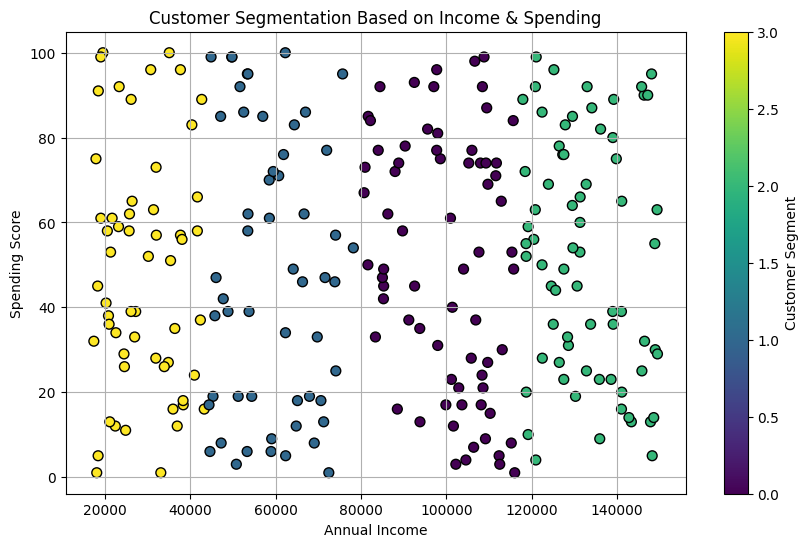

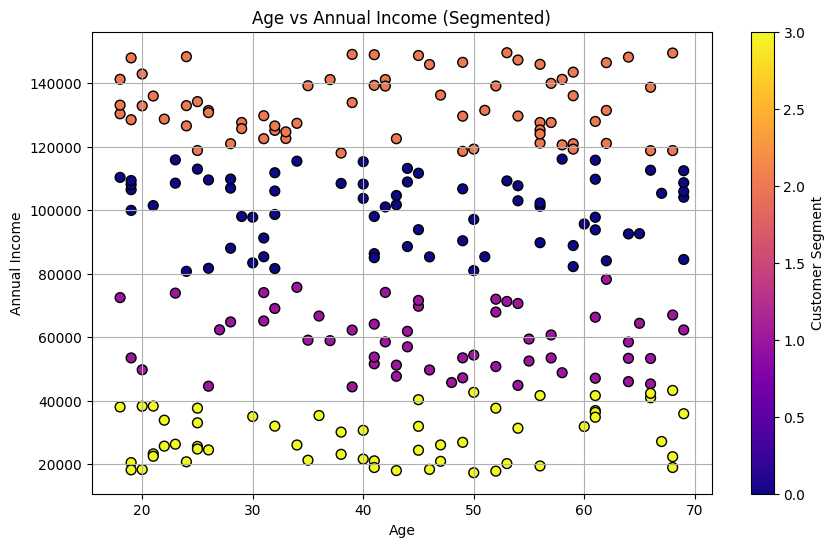


 Recommended Products for Customer ID 158:
    product_id    product_name
2          103  Leather Wallet
3          104   Running Shoes
10         111    Coffee Maker

 Sample Synthetic Reviews:
      customer_id  product_id                            review  \
1798        206.0       110.0   Fantastic product, great value!   
2115        243.0       101.0     It was okay, nothing special.   
1463        168.0       108.0  Very satisfied with the quality.   
2091        240.0       111.0     It was okay, nothing special.   
572          66.0       115.0     It was okay, nothing special.   

      sentiment_score  
1798         0.700000  
2115         0.428571  
1463         0.650000  
2091         0.428571  
572          0.428571  


In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
import random

# Loading customer data
def load_customer_data(csv_file_path):
    customer_df = pd.read_csv(csv_file_path)
    return customer_df

# Generating a realistic product catalog
def generate_product_catalog():
    product_catalog = [
        "Wireless Earbuds", "Smart Watch", "Leather Wallet", "Running Shoes", "Bluetooth Speaker",
        "Scented Candles", "Laptop Backpack", "Gaming Mouse", "Organic Skincare Set", "Fitness Tracker",
        "Coffee Maker", "Noise Cancelling Headphones", "Stylish Sunglasses", "Portable Charger", "Smart LED Bulb"]
    product_ids = np.arange(101, 101 + len(product_catalog))
    product_df = pd.DataFrame({
        'product_id': product_ids,
        'product_name': product_catalog})
    return product_df

# Segmenting customers into clusters
def segment_customers_by_behavior(customer_df, num_segments=4):
    kmeans_model = KMeans(n_clusters=num_segments, random_state=42, n_init=10)
    customer_df['segment'] = kmeans_model.fit_predict(customer_df[['annual_income', 'spending_score']])
    return customer_df

# Simulating customer product ratings with some missing entries
def simulate_customer_ratings(customer_df, product_df):
    ratings_list = []
    for _, customer in customer_df.iterrows():
        for _, product in product_df.iterrows():
            if random.random() < 0.6:  # 60% chance of rating a product
                base_rating = np.random.normal(3, 1)
                random_noise = np.random.uniform(-0.5, 0.5)
                segment_bias = customer['segment'] * 0.5
                final_rating = min(max(base_rating + random_noise + segment_bias, 1), 5)

                ratings_list.append({
                    'customer_id': customer['customer_id'],
                    'product_id': product['product_id'],
                    'rating': round(final_rating, 1)
                })
    return pd.DataFrame(ratings_list)

# Recommending products based on customer similarity
def recommend_products_for_customer(ratings_df, target_customer_id, product_df, top_n=3):
    customer_product_matrix = ratings_df.pivot_table(index='customer_id', columns='product_id', values='rating')
    similarity_matrix = cosine_similarity(customer_product_matrix.fillna(0))
    customer_index = customer_product_matrix.index.get_loc(target_customer_id)
    customer_similarities = similarity_matrix[customer_index]
    similarity_series = pd.Series(customer_similarities, index=customer_product_matrix.index)
    similarity_series = similarity_series.drop(target_customer_id).sort_values(ascending=False)
    most_similar_customer_id = similarity_series.index[0]
    similar_customer_ratings = customer_product_matrix.loc[most_similar_customer_id]
    unrated_products = customer_product_matrix.loc[target_customer_id][customer_product_matrix.loc[target_customer_id].isna()].index
    recommended_products = similar_customer_ratings.loc[unrated_products].sort_values(ascending=False).head(top_n)
    recommended_product_details = product_df[product_df['product_id'].isin(recommended_products.index)]
    return recommended_product_details

# Generating product reviews and sentiment scores
positive_review_templates = [
    "Absolutely loved it!",
    "Exceeded expectations!",
    "Would definitely recommend!",
    "Very satisfied with the quality.",
    "Fantastic product, great value!"
]

negative_review_templates = [
    "Not worth the price.",
    "Disappointed with the product.",
    "Would not buy again.",
    "Poor quality and service.",
    "Extremely dissatisfied with this purchase."
]

def create_synthetic_reviews(ratings_df):
    review_entries = []
    for _, rating_record in ratings_df.iterrows():
        if rating_record['rating'] >= 4:
            review_text = random.choice(positive_review_templates)
        elif rating_record['rating'] <= 2:
            review_text = random.choice(negative_review_templates)
        else:
            review_text = "It was okay, nothing special."

        sentiment_score = TextBlob(review_text).sentiment.polarity

        review_entries.append({
            'customer_id': rating_record['customer_id'],
            'product_id': rating_record['product_id'],
            'review': review_text,
            'sentiment_score': sentiment_score
        })
    return pd.DataFrame(review_entries)

# Visualizing customer segments
def plot_customer_segments(customer_df):
    plt.figure(figsize=(10,6))
    scatter_plot = plt.scatter(customer_df['annual_income'], customer_df['spending_score'],
                                c=customer_df['segment'], cmap='viridis', s=50, edgecolor='k')
    plt.title('Customer Segmentation Based on Income & Spending')
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')
    plt.colorbar(scatter_plot, label='Customer Segment')
    plt.grid(True)
    plt.show()

# Visualizing Age vs Income by customer segment
def plot_age_vs_income(customer_df):
    plt.figure(figsize=(10,6))
    scatter_plot = plt.scatter(customer_df['age'], customer_df['annual_income'],
                                c=customer_df['segment'], cmap='plasma', s=50, edgecolor='k')
    plt.title('Age vs Annual Income (Segmented)')
    plt.xlabel('Age')
    plt.ylabel('Annual Income')
    plt.colorbar(scatter_plot, label='Customer Segment')
    plt.grid(True)
    plt.show()

# Loading customer dataset
customer_df = load_customer_data('customers.csv')

# Creating product catalog
product_df = generate_product_catalog()

# Segmenting customers
customer_df = segment_customers_by_behavior(customer_df)

# Simulating ratings
ratings_df = simulate_customer_ratings(customer_df, product_df)

# Generating reviews
reviews_df = create_synthetic_reviews(ratings_df)

# Visualizations
plot_customer_segments(customer_df)
plot_age_vs_income(customer_df)

# Recommending products for a random customer
random_customer_id = random.choice(customer_df['customer_id'].tolist())
recommended_products_df = recommend_products_for_customer(ratings_df, random_customer_id, product_df)

print(f"\n Recommended Products for Customer ID {random_customer_id}:")
print(recommended_products_df)

# Show some generated reviews
print("\n Sample Synthetic Reviews:")
print(reviews_df.sample(5))

